## Add path to source files

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.path.abspath('..'), 'src'))

## If not already created, make folder to save figures from this simulation

In [2]:
save_folder = r'tactoid-simulation-figures'
if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

## Import necessary packages, format figures, display loading bars

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import FiniteDifference as fd
import LiquidCrystalHelper as lch

from importlib import reload

In [4]:
import ipywidgets as widgets
from IPython.display import display

In [5]:
reload(lch)

<module 'LiquidCrystalHelper' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHydrodynamics\\src\\LiquidCrystalHelper.py'>

In [6]:
%matplotlib inline
dpi = 600
mpl.rcParams['figure.dpi'] = dpi

# Forward Euler Tactoid Simulation

### 1. Generate a domain

In [7]:
l = 10
n = 300

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

### 2. Generate a tactoid on that domain

In [8]:
S_val = 1
ctr = [0, 0]
r = 2
m = 1

S, phi = lch.makeTactoid(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)

### 3. Get $\eta$, $\mu$, and $\nu$ values for that configuration.

In [9]:
eta, mu, nu = lch.auxVars(Q)

### 4. Calculate eigenvalues/vectors, generate sparse gridpoints

In [10]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_max = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_max, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

### 5. Plot

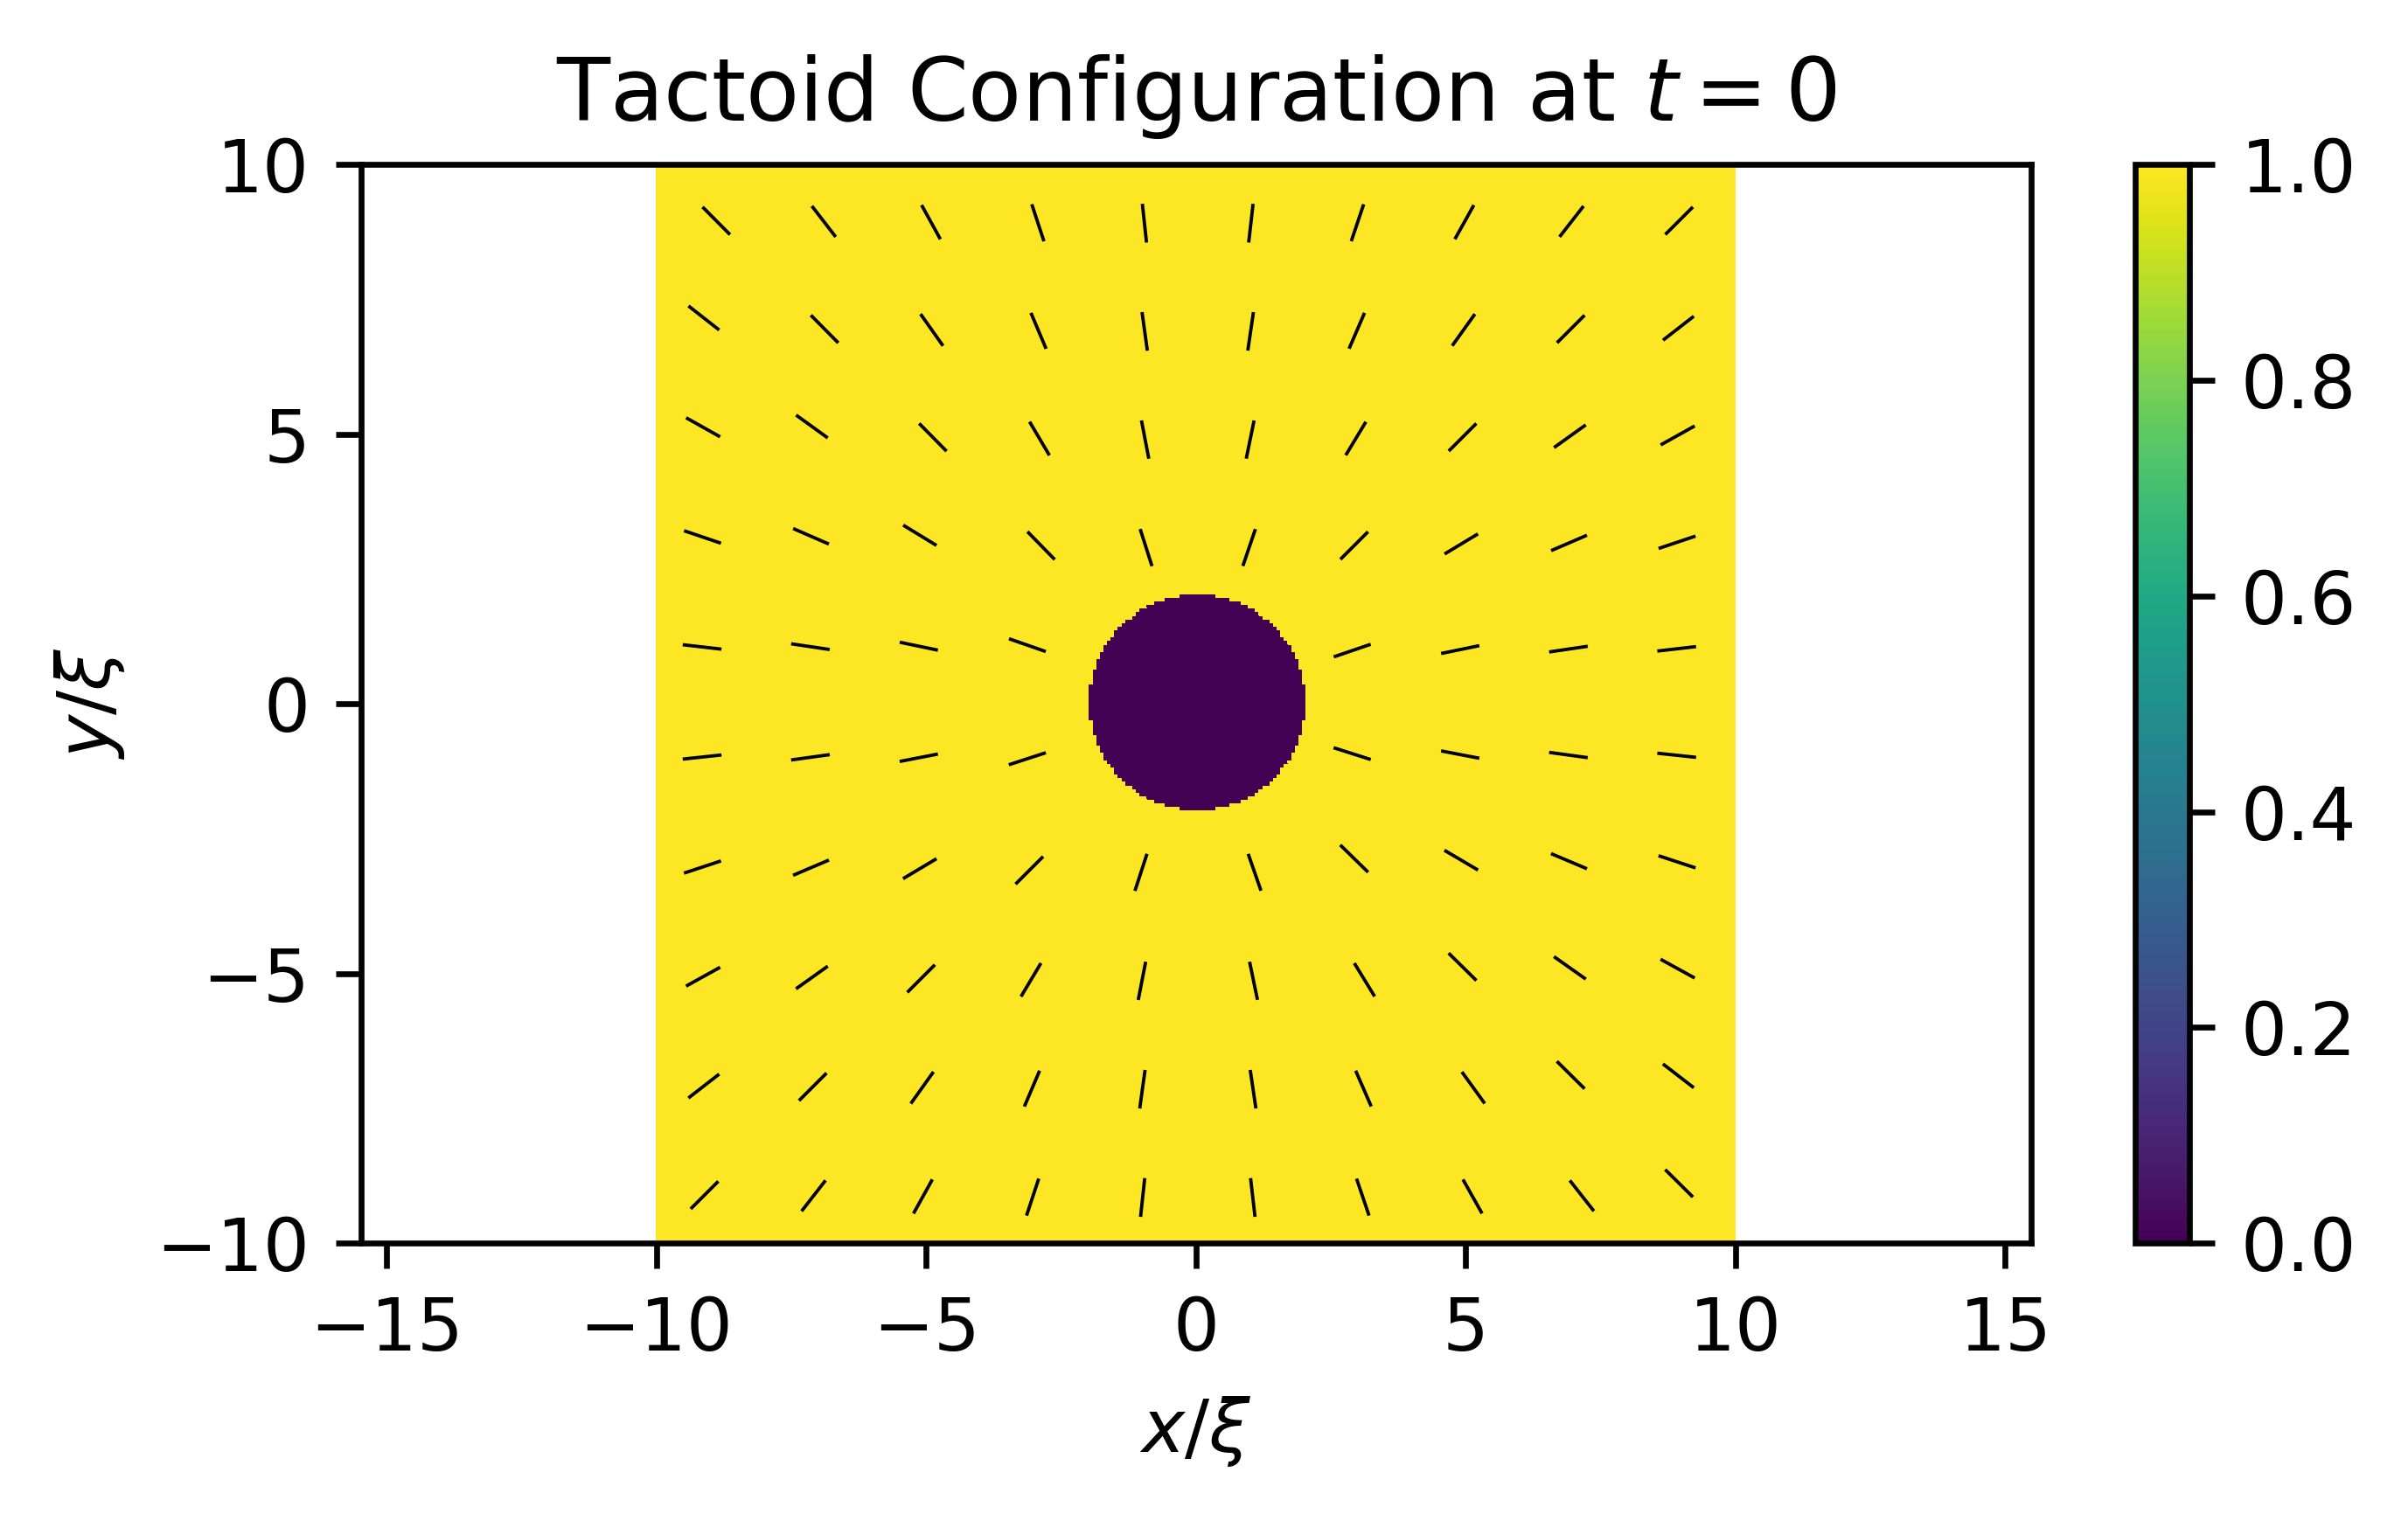

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], S[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
ax.axis('equal')
fig.colorbar(c, ax=ax)

ax.set_title(r"Tactoid Configuration at $t = 0$")
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")
fig.tight_layout()

filename1 = os.path.join(save_folder, r'tactoid-t0-config.png')
fig.savefig(filename1)

### 6. Step forward time `dt` for `num_steps` steps

In [12]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/4
num_steps = 5000

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

eta_old = eta
mu_old = mu
nu_old = nu

for i in range(num_steps):
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    progress.value = i

IntProgress(value=0, max=5000)

### 7. Plot time evolution

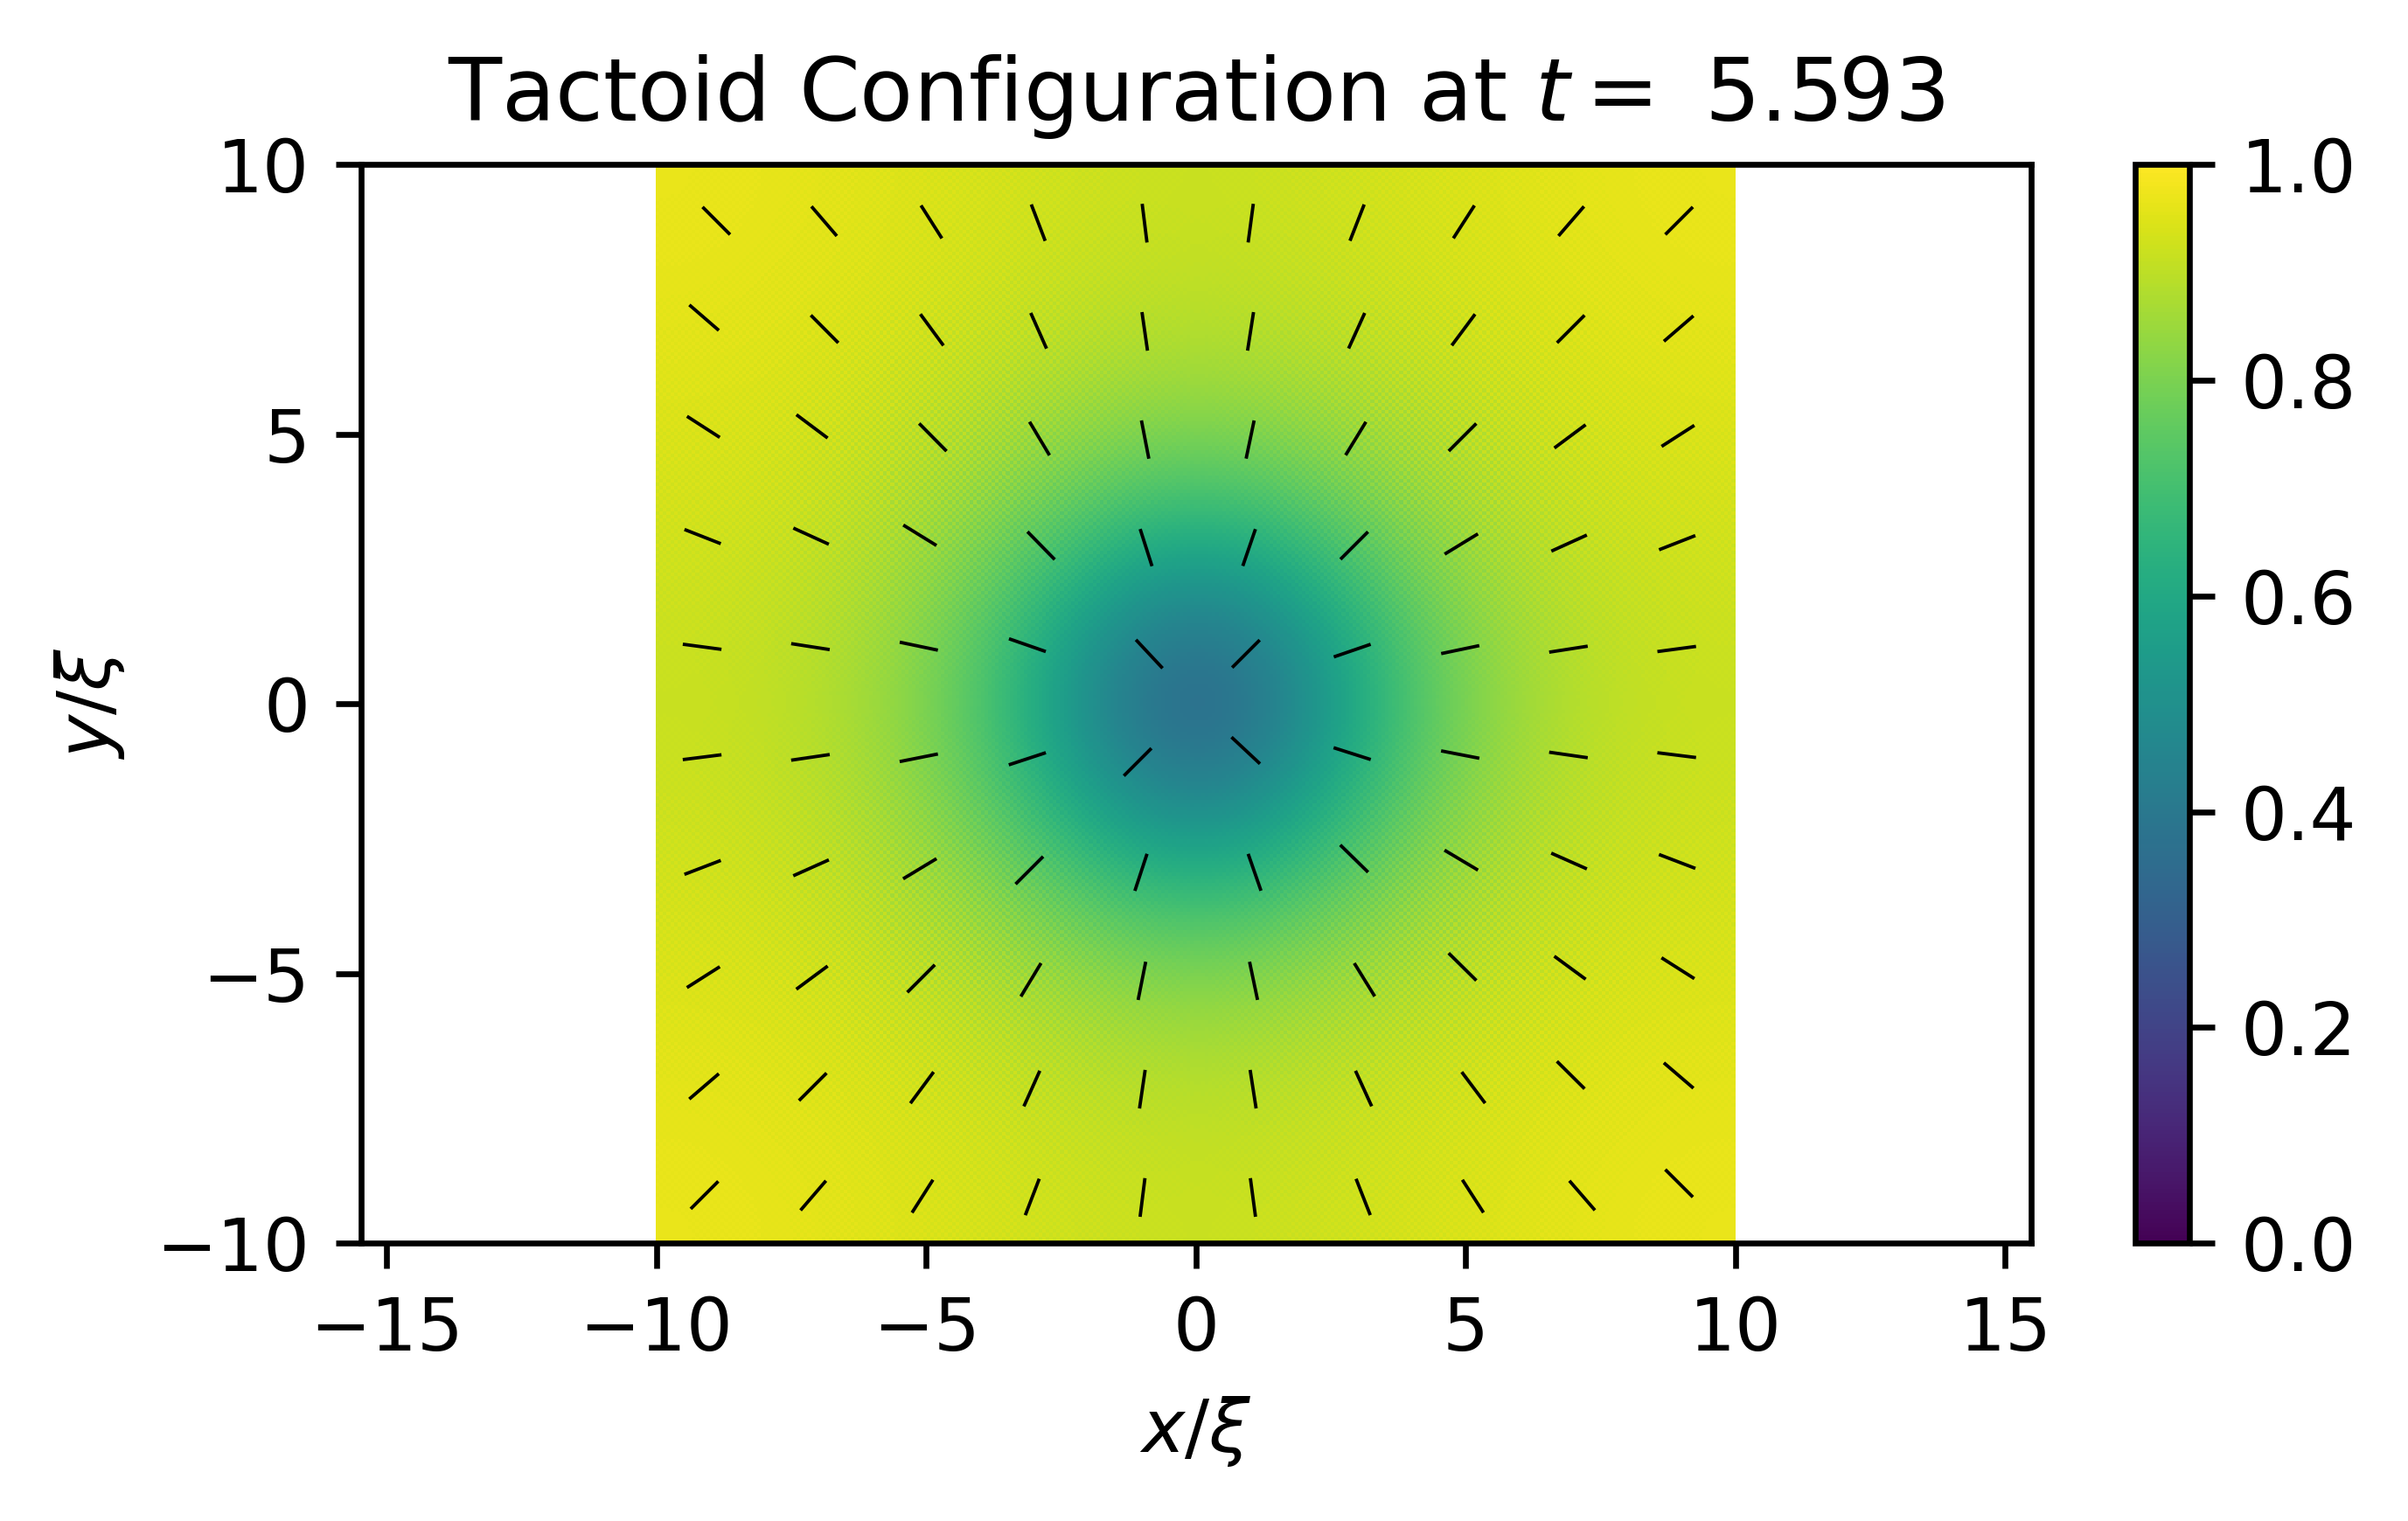

In [13]:
sparse_shape = (10, 10)
S_sparse_shape = (300, 300)
S_cutoff = 0.1

lambda_pm = lch.calcQEigenvals(eta_old, mu_old, nu_old)
U, V = lch.calcQEigenvecs(eta_old, mu_old, nu_old, lambda_pm, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], (3/2)*lambda_pm[S_sparse_idx], vmin=0, vmax=1)
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
ax.axis('equal')
fig.colorbar(c, ax=ax)

ax.set_title(r"Tactoid Configuration at $t = $ " + str(round(dt*num_steps, 3)))
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")
fig.tight_layout()

filename2 = os.path.join(save_folder, r'tactoid-tf-config.png')
fig.savefig(filename2)